In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import cholesky
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("="*80)
print("KALMAN FILTERS IMPLEMENTATION FOR GAMING DATA")
print("KF | EKF | UKF")
print("="*80)

KALMAN FILTERS IMPLEMENTATION FOR GAMING DATA
KF | EKF | UKF



# ============================================================================
# PROBLEM STATEMENT
# ============================================================================
"""
PROBLEM: Player Engagement Prediction Using Kalman Filters

Context:
You have a gaming dataset with various player metrics. The goal is to use
Kalman Filters to:
1. Smooth noisy measurements (e.g., PlayTimeHours, SessionsPerWeek)
2. Predict future player engagement trends
3. Filter out measurement noise to get true player behavior

Applications:
- Predict player churn before it happens
- Smooth playtime data for better analytics
- Track real engagement despite noisy session data
- Estimate hidden player states (motivation, satisfaction)

We'll implement three types of Kalman Filters:
- KF: Standard Kalman Filter (linear systems)
- EKF: Extended Kalman Filter (handles nonlinear relationships)
- UKF: Unscented Kalman Filter (better for highly nonlinear systems)
"""

In [2]:

# ============================================================================
# 1. LOAD AND PREPARE DATA
# ============================================================================

# Load the dataset
file_path = '/Users/ebricks/Desktop/ml-statistical-gaming-analysis/data/processed/gaming_data_processed.csv'
df = pd.read_csv(file_path)

print(f"\nDataset Shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())
print(f"\nDataset Info:")
print(df.info())


Dataset Shape: (40034, 16)

First few rows:
   PlayerID       Age  Gender  Location  GameGenre  PlayTimeHours  \
0      9000  1.096023       1         2          4       0.614176   
1      9001 -0.297969       0         3          4      -0.939816   
2      9002 -0.994965       0         3          3      -0.549654   
3      9003  0.299456       1         3          0      -0.977506   
4      9004  0.100314       1         1          0       0.507275   

   InGamePurchases  GameDifficulty  SessionsPerWeek  \
0                0               2        -0.602363   
1                0               2        -0.775865   
2                0               0         1.132666   
3                1               0        -0.081854   
4                0               2        -1.296374   

   AvgSessionDurationMinutes  PlayerLevel  AchievementsUnlocked  \
0                   0.269487     1.026459              0.032814   
1                   1.004019    -1.352160             -1.006648   
2       

In [3]:
# Select a metric to filter (you can change this)
METRIC = 'PlayTimeHours'  # Change to 'SessionsPerWeek', 'playtime_per_week', etc.

# Extract the time series
measurements = df[METRIC].values
n_samples = len(measurements)

print(f"\n{'='*80}")
print(f"FILTERING METRIC: {METRIC}")
print(f"Number of samples: {n_samples}")
print(f"Mean: {np.mean(measurements):.4f}")
print(f"Std: {np.std(measurements):.4f}")
print(f"{'='*80}\n")


FILTERING METRIC: PlayTimeHours
Number of samples: 40034
Mean: 0.0000
Std: 1.0000



In [4]:

# ============================================================================
# 2. STANDARD KALMAN FILTER (KF)
# ============================================================================

class KalmanFilter:
    """
    Standard Kalman Filter for linear systems
    
    State space model:
    x(k+1) = F * x(k) + w(k)    # State transition
    z(k) = H * x(k) + v(k)       # Measurement
    
    where:
    - w(k) ~ N(0, Q): process noise
    - v(k) ~ N(0, R): measurement noise
    """
    
    def __init__(self, F, H, Q, R, x0, P0):
        self.F = F  # State transition matrix
        self.H = H  # Observation matrix
        self.Q = Q  # Process noise covariance
        self.R = R  # Measurement noise covariance
        self.x = x0  # Initial state
        self.P = P0  # Initial covariance
        
    def predict(self):
        """Prediction step"""
        self.x = self.F @ self.x
        self.P = self.F @ self.P @ self.F.T + self.Q
        
    def update(self, z):
        """Update step with measurement z"""
        # Innovation
        y = z - self.H @ self.x
        
        # Innovation covariance
        S = self.H @ self.P @ self.H.T + self.R
        
        # Kalman gain
        K = self.P @ self.H.T @ np.linalg.inv(S)
        
        # State update
        self.x = self.x + K @ y
        
        # Covariance update
        I = np.eye(len(self.x))
        self.P = (I - K @ self.H) @ self.P
        
    def filter(self, measurements):
        """Filter entire sequence"""
        filtered = []
        
        for z in measurements:
            self.predict()
            self.update(np.array([[z]]))
            filtered.append(self.x[0, 0])
            
        return np.array(filtered)

# Initialize KF
F = np.array([[1.0]])  # State transition (simple persistence model)
H = np.array([[1.0]])  # Observation model (direct observation)
Q = np.array([[0.01]])  # Process noise (tune this)
R = np.array([[0.5]])   # Measurement noise (tune this)
x0 = np.array([[measurements[0]]])
P0 = np.array([[1.0]])

kf = KalmanFilter(F, H, Q, R, x0, P0)
kf_filtered = kf.filter(measurements)

print(" Standard Kalman Filter completed")


 Standard Kalman Filter completed


In [5]:

# ============================================================================
# 3. EXTENDED KALMAN FILTER (EKF)
# ============================================================================

class ExtendedKalmanFilter:
    """
    Extended Kalman Filter for nonlinear systems
    
    Uses first-order Taylor expansion (Jacobians) to linearize
    nonlinear functions.
    """
    
    def __init__(self, f, h, F_jacobian, H_jacobian, Q, R, x0, P0):
        self.f = f  # Nonlinear state transition function
        self.h = h  # Nonlinear observation function
        self.F_jacobian = F_jacobian  # Jacobian of f
        self.H_jacobian = H_jacobian  # Jacobian of h
        self.Q = Q
        self.R = R
        self.x = x0
        self.P = P0
        
    def predict(self):
        """Prediction step"""
        # Compute Jacobian at current state
        F = self.F_jacobian(self.x)
        
        # Nonlinear state prediction
        self.x = self.f(self.x)
        
        # Covariance prediction
        self.P = F @ self.P @ F.T + self.Q
        
    def update(self, z):
        """Update step"""
        # Compute Jacobian at predicted state
        H = self.H_jacobian(self.x)
        
        # Innovation
        y = z - self.h(self.x)
        
        # Innovation covariance
        S = H @ self.P @ H.T + self.R
        
        # Kalman gain
        K = self.P @ H.T @ np.linalg.inv(S)
        
        # State update
        self.x = self.x + K @ y
        
        # Covariance update
        I = np.eye(len(self.x))
        self.P = (I - K @ H) @ self.P
        
    def filter(self, measurements):
        """Filter entire sequence"""
        filtered = []
        
        for z in measurements:
            self.predict()
            self.update(np.array([[z]]))
            filtered.append(self.x[0, 0])
            
        return np.array(filtered)


In [6]:
# Define nonlinear functions for EKF
def f_nonlinear(x):
    """Nonlinear state transition: x(k+1) = x(k) + 0.01*sin(x(k))"""
    return x + 0.01 * np.sin(x)

def h_nonlinear(x):
    """Nonlinear observation: z(k) = x(k)"""
    return x

def F_jacobian(x):
    """Jacobian of f"""
    return np.array([[1.0 + 0.01 * np.cos(x[0, 0])]])

def H_jacobian(x):
    """Jacobian of h"""
    return np.array([[1.0]])

# Initialize EKF
ekf = ExtendedKalmanFilter(
    f_nonlinear, h_nonlinear, 
    F_jacobian, H_jacobian,
    Q, R, x0.copy(), P0.copy()
)
ekf_filtered = ekf.filter(measurements)

print("Extended Kalman Filter completed")

Extended Kalman Filter completed


In [7]:

# ============================================================================
# 4. UNSCENTED KALMAN FILTER (UKF)
# ============================================================================

class UnscentedKalmanFilter:
    """
    Unscented Kalman Filter
    
    Uses unscented transform with sigma points to handle
    nonlinear transformations without linearization.
    """
    
    def __init__(self, f, h, Q, R, x0, P0, alpha=0.001, beta=2, kappa=0):
        self.f = f
        self.h = h
        self.Q = Q
        self.R = R
        self.x = x0
        self.P = P0
        
        # UKF parameters
        self.n = len(x0)
        self.alpha = alpha
        self.beta = beta
        self.kappa = kappa
        
        # Compute lambda and weights
        self.lambda_ = alpha**2 * (self.n + kappa) - self.n
        self.gamma = np.sqrt(self.n + self.lambda_)
        
        # Weights for mean
        self.Wm = np.zeros(2 * self.n + 1)
        self.Wm[0] = self.lambda_ / (self.n + self.lambda_)
        self.Wm[1:] = 0.5 / (self.n + self.lambda_)
        
        # Weights for covariance
        self.Wc = np.zeros(2 * self.n + 1)
        self.Wc[0] = self.lambda_ / (self.n + self.lambda_) + (1 - alpha**2 + beta)
        self.Wc[1:] = 0.5 / (self.n + self.lambda_)
        
    def generate_sigma_points(self, x, P):
        """Generate sigma points"""
        sigma_points = np.zeros((2 * self.n + 1, self.n))
        sigma_points[0] = x.flatten()
        
        try:
            sqrt_P = cholesky((self.n + self.lambda_) * P, lower=True)
        except:
            # If Cholesky fails, use eigenvalue decomposition
            eigvals, eigvecs = np.linalg.eigh(P)
            eigvals = np.maximum(eigvals, 1e-10)
            sqrt_P = eigvecs @ np.diag(np.sqrt(eigvals * (self.n + self.lambda_)))
        
        for i in range(self.n):
            sigma_points[i + 1] = x.flatten() + sqrt_P[:, i]
            sigma_points[self.n + i + 1] = x.flatten() - sqrt_P[:, i]
            
        return sigma_points
    
    def predict(self):
        """Prediction step"""
        # Generate sigma points
        sigma_points = self.generate_sigma_points(self.x, self.P)
        
        # Transform sigma points through f
        sigma_points_f = np.array([self.f(sp.reshape(-1, 1)).flatten() 
                                   for sp in sigma_points])
        
        # Compute predicted mean
        self.x = np.sum(self.Wm[:, np.newaxis] * sigma_points_f, axis=0).reshape(-1, 1)
        
        # Compute predicted covariance
        self.P = self.Q.copy()
        for i in range(2 * self.n + 1):
            diff = (sigma_points_f[i] - self.x.flatten()).reshape(-1, 1)
            self.P += self.Wc[i] * (diff @ diff.T)
            
    def update(self, z):
        """Update step"""
        # Generate sigma points
        sigma_points = self.generate_sigma_points(self.x, self.P)
        
        # Transform sigma points through h
        sigma_points_h = np.array([self.h(sp.reshape(-1, 1)).flatten() 
                                   for sp in sigma_points])
        
        # Predicted measurement
        z_pred = np.sum(self.Wm[:, np.newaxis] * sigma_points_h, axis=0).reshape(-1, 1)
        
        # Innovation covariance
        Pzz = self.R.copy()
        for i in range(2 * self.n + 1):
            diff = (sigma_points_h[i] - z_pred.flatten()).reshape(-1, 1)
            Pzz += self.Wc[i] * (diff @ diff.T)
        
        # Cross-covariance
        Pxz = np.zeros((self.n, z.shape[0]))
        for i in range(2 * self.n + 1):
            dx = (sigma_points[i] - self.x.flatten()).reshape(-1, 1)
            dz = (sigma_points_h[i] - z_pred.flatten()).reshape(-1, 1)
            Pxz += self.Wc[i] * (dx @ dz.T)
        
        # Kalman gain
        K = Pxz @ np.linalg.inv(Pzz)
        
        # Update state
        self.x = self.x + K @ (z - z_pred)
        
        # Update covariance
        self.P = self.P - K @ Pzz @ K.T
        
    def filter(self, measurements):
        """Filter entire sequence"""
        filtered = []
        
        for z in measurements:
            self.predict()
            self.update(np.array([[z]]))
            filtered.append(self.x[0, 0])
            
        return np.array(filtered)


In [8]:
# Define nonlinear functions for UKF
def f_ukf(x):
    """Nonlinear state transition"""
    return x + 0.01 * np.sin(x)

def h_ukf(x):
    """Observation function"""
    return x

# Initialize UKF
ukf = UnscentedKalmanFilter(
    f_ukf, h_ukf, Q, R, x0.copy(), P0.copy()
)
ukf_filtered = ukf.filter(measurements)

print(" Unscented Kalman Filter completed")

 Unscented Kalman Filter completed


In [10]:
# ============================================================================
# 5. PERFORMANCE EVALUATION
# ============================================================================

def calculate_metrics(original, filtered):
    """Calculate performance metrics"""
    mse = mean_squared_error(original, filtered)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(original, filtered)
    
    return {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae
    }

print("\n" + "="*80)
print("PERFORMANCE METRICS")
print("="*80)



kf_metrics = calculate_metrics(measurements, kf_filtered)
ekf_metrics = calculate_metrics(measurements, ekf_filtered)
ukf_metrics = calculate_metrics(measurements, ukf_filtered)

print(f"\nKalman Filter (KF):")
for metric, value in kf_metrics.items():
    print(f"  {metric}: {value:.6f}")

print(f"\nExtended Kalman Filter (EKF):")
for metric, value in ekf_metrics.items():
    print(f"  {metric}: {value:.6f}")

print(f"\nUnscented Kalman Filter (UKF):")
for metric, value in ukf_metrics.items():
    print(f"  {metric}: {value:.6f}")


PERFORMANCE METRICS

Kalman Filter (KF):
  MSE: 0.806131
  RMSE: 0.897848
  MAE: 0.769395

Extended Kalman Filter (EKF):
  MSE: 0.799381
  RMSE: 0.894081
  MAE: 0.765021

Unscented Kalman Filter (UKF):
  MSE: 0.799215
  RMSE: 0.893988
  MAE: 0.764964



✓ Plot saved as 'kalman_filters_comparison.png'


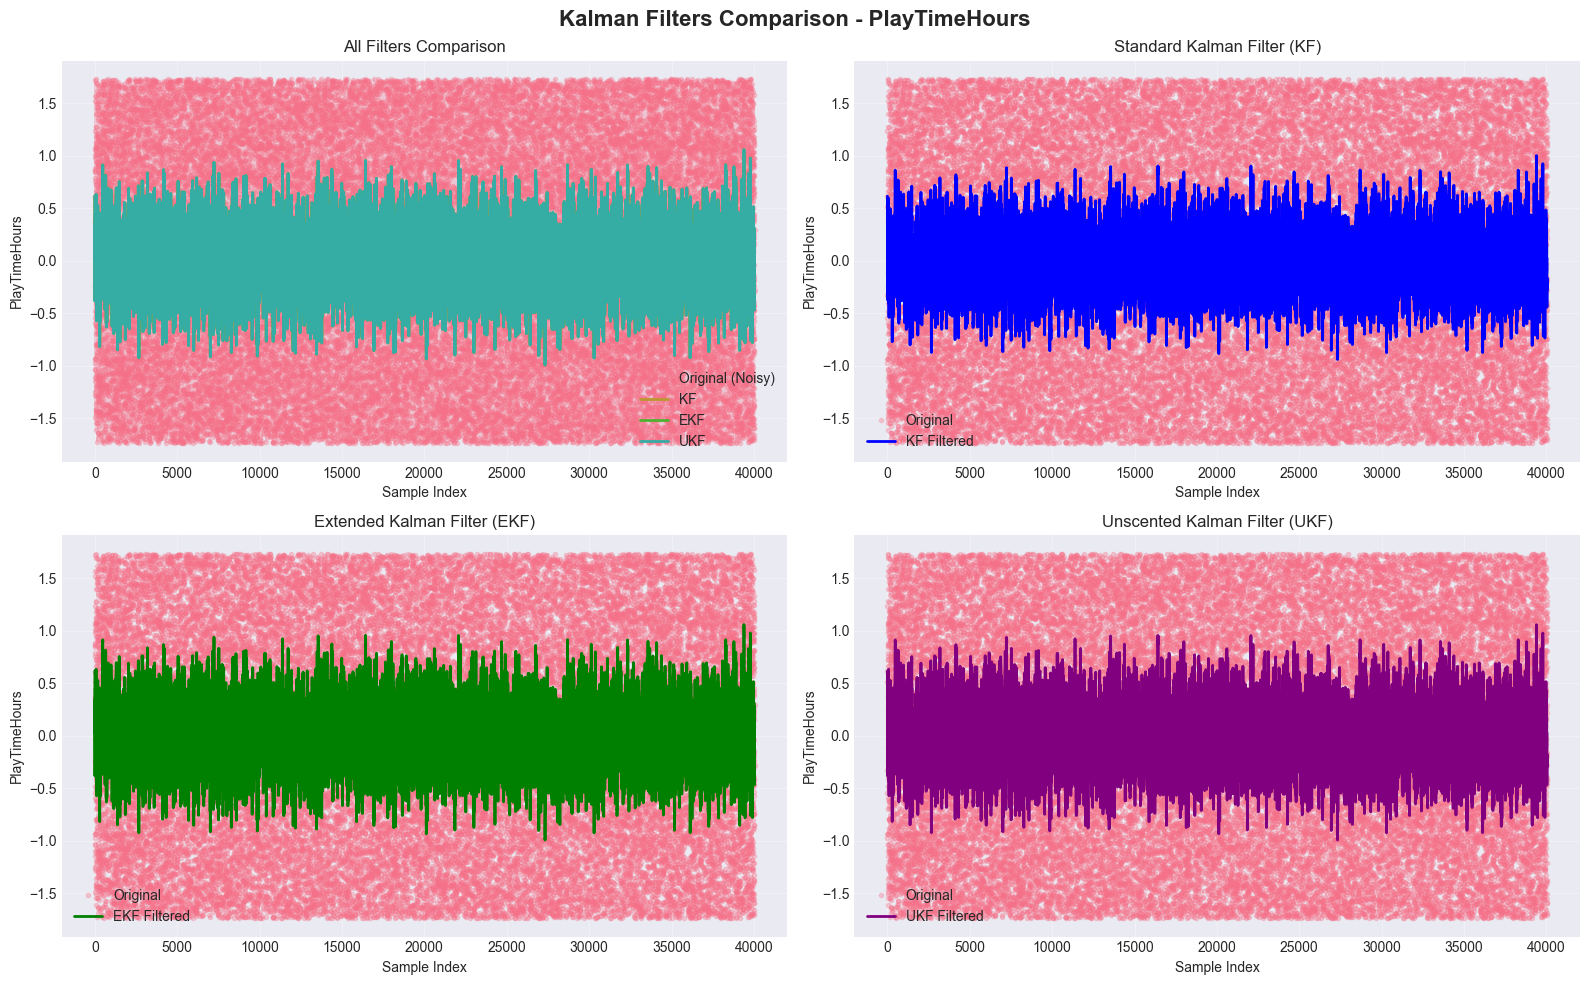

✓ Error plot saved as 'kalman_filters_errors.png'


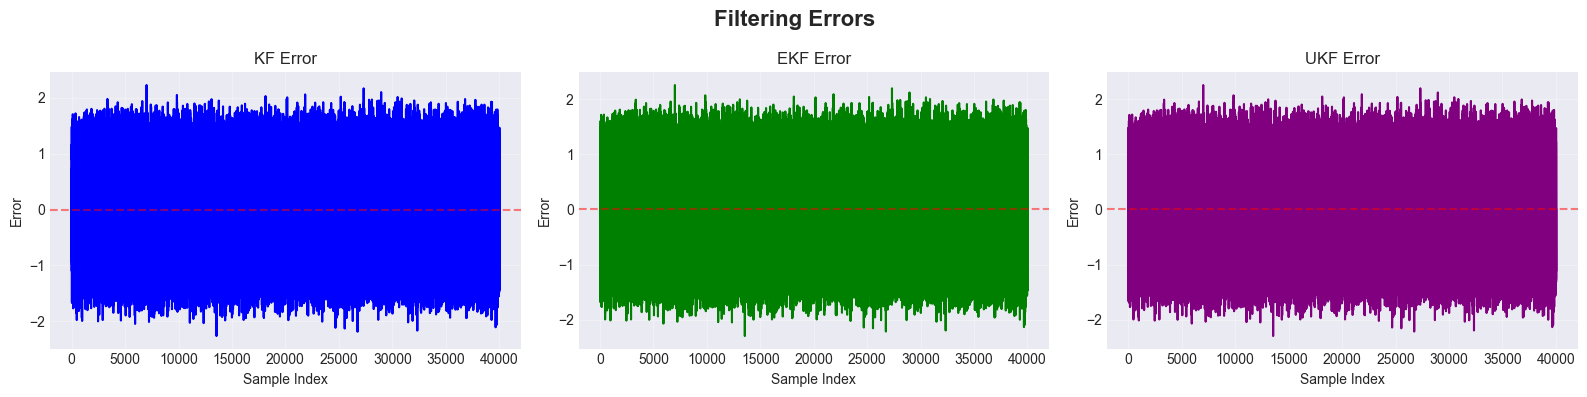

In [11]:
# ============================================================================
# 6. VISUALIZATION
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle(f'Kalman Filters Comparison - {METRIC}', fontsize=16, fontweight='bold')

# Plot 1: All filters comparison
ax1 = axes[0, 0]
ax1.plot(measurements, 'o-', alpha=0.3, label='Original (Noisy)', markersize=3, linewidth=1)
ax1.plot(kf_filtered, '-', label='KF', linewidth=2)
ax1.plot(ekf_filtered, '-', label='EKF', linewidth=2)
ax1.plot(ukf_filtered, '-', label='UKF', linewidth=2)
ax1.set_xlabel('Sample Index')
ax1.set_ylabel(METRIC)
ax1.set_title('All Filters Comparison')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Individual filter - KF
ax2 = axes[0, 1]
ax2.plot(measurements, 'o', alpha=0.3, label='Original', markersize=3)
ax2.plot(kf_filtered, '-', label='KF Filtered', linewidth=2, color='blue')
ax2.set_xlabel('Sample Index')
ax2.set_ylabel(METRIC)
ax2.set_title('Standard Kalman Filter (KF)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Individual filter - EKF
ax3 = axes[1, 0]
ax3.plot(measurements, 'o', alpha=0.3, label='Original', markersize=3)
ax3.plot(ekf_filtered, '-', label='EKF Filtered', linewidth=2, color='green')
ax3.set_xlabel('Sample Index')
ax3.set_ylabel(METRIC)
ax3.set_title('Extended Kalman Filter (EKF)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Individual filter - UKF
ax4 = axes[1, 1]
ax4.plot(measurements, 'o', alpha=0.3, label='Original', markersize=3)
ax4.plot(ukf_filtered, '-', label='UKF Filtered', linewidth=2, color='purple')
ax4.set_xlabel('Sample Index')
ax4.set_ylabel(METRIC)
ax4.set_title('Unscented Kalman Filter (UKF)')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('kalman_filters_comparison.png', dpi=300, bbox_inches='tight')
print("\n✓ Plot saved as 'kalman_filters_comparison.png'")
plt.show()

# Plot error analysis
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
fig.suptitle('Filtering Errors', fontsize=16, fontweight='bold')

kf_error = measurements - kf_filtered
ekf_error = measurements - ekf_filtered
ukf_error = measurements - ukf_filtered

axes[0].plot(kf_error, label='KF Error', color='blue')
axes[0].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[0].set_title('KF Error')
axes[0].set_xlabel('Sample Index')
axes[0].set_ylabel('Error')
axes[0].grid(True, alpha=0.3)

axes[1].plot(ekf_error, label='EKF Error', color='green')
axes[1].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[1].set_title('EKF Error')
axes[1].set_xlabel('Sample Index')
axes[1].set_ylabel('Error')
axes[1].grid(True, alpha=0.3)

axes[2].plot(ukf_error, label='UKF Error', color='purple')
axes[2].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[2].set_title('UKF Error')
axes[2].set_xlabel('Sample Index')
axes[2].set_ylabel('Error')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('kalman_filters_errors.png', dpi=300, bbox_inches='tight')
print("✓ Error plot saved as 'kalman_filters_errors.png'")
plt.show()


In [14]:
# ============================================================================
# 7. RESULTS SUMMARY
# ============================================================================

print("\n" + "="*80)
print("SUMMARY")
print("="*80)

results_df = pd.DataFrame({
    'Filter': ['KF', 'EKF', 'UKF'],
    'MSE': [kf_metrics['MSE'], ekf_metrics['MSE'], ukf_metrics['MSE']],
    'RMSE': [kf_metrics['RMSE'], ekf_metrics['RMSE'], ukf_metrics['RMSE']],
    'MAE': [kf_metrics['MAE'], ekf_metrics['MAE'], ukf_metrics['MAE']]
})

print("\nPerformance Comparison:")
print(results_df.to_string(index=False))

best_filter = results_df.loc[results_df['RMSE'].idxmin(), 'Filter']
print(f"\nBest Filter (lowest RMSE): {best_filter}")


print("\n Analysis Complete!")
print("="*80)


SUMMARY

Performance Comparison:
Filter      MSE     RMSE      MAE
    KF 0.806131 0.897848 0.769395
   EKF 0.799381 0.894081 0.765021
   UKF 0.799215 0.893988 0.764964

Best Filter (lowest RMSE): UKF

 Analysis Complete!
